# Topic Project: Applying NLP for Topic Modelling in a Healthcare Context

## Project Overview

This project demonstrates the application of **Natural Language Processing (NLP)** techniques to perform automated topic modelling on patient feedback data. The aim is to identify key themes, common concerns, and actionable insights from textual reviews, bridging the gap between theory and practical application in a healthcare context.

Applying NLP for topic modelling is critical in business and healthcare because it enables organisations to uncover **patterns and trends in large volumes of text data**, such as customer or patient reviews, research articles, or clinical notes. This allows for **efficient decision-making**, improved resource allocation, and enhanced understanding of user experience without manually reading thousands of documents.

## Key Skills Demonstrated

* Investigate textual data to identify meaningful trends.
* Preprocess and refine data for visualisations and analysis.
* Apply topic modelling using advanced NLP techniques.
* Conduct emotion analysis on text to detect sentiment patterns.
* Communicate actionable insights derived from textual data.

## Business Context

This project simulates patient feedback analysis for a **hospital environment**. The focus is on understanding factors that influence patient experiences and satisfaction, particularly identifying common drivers behind negative reviews. While the dataset simulates a realistic environment, it is entirely **synthetic** — all reviews, scores, locations, and patient information are **fictitious** and bear no relation to real hospitals or patients.

The synthetic datasets contain:

* **5,000 reviews from Google**
* **5,000 reviews from Trustpilot**

Each review includes:

* Patient feedback text
* Review rating (1–5 stars)
* Hospital location

Negative reviews (scores <3) are filtered to focus on areas of potential improvement. This allows us to demonstrate topic modelling and emotion analysis workflows in a controlled, reproducible setting.

## Data Preparation

Key preprocessing steps include:

* Removing missing or empty reviews.
* Standardising text (lowercasing, punctuation removal).
* Removing stopwords and numbers using **NLTK**.
* Tokenising reviews into words for analysis.
* Filtering reviews by sentiment (negative reviews) and by hospital location.


## Topic Modelling Approach

### **BERTopic Workflow**

* **Objective:** Identify the main themes in negative patient reviews.

* **Methodology:**

  * Merged Google and Trustpilot negative reviews from common locations.
  * Applied **BERTopic** for unsupervised topic extraction.
  * Generated visualisations including topic distributions, top keywords per topic, inter-topic distance maps, and heatmaps of topic similarity.
  * Analysed location-level trends to identify hospitals with recurring negative feedback.

* **Outcome:**

  * Clusters of patient concerns were identified, e.g., **cleanliness, staff behavior, waiting times, treatment quality**, providing clear targets for improvement.
  * BERTopic allowed for **interpretable and actionable results**, summarising complex textual data into manageable insights.

In [1]:
!pip install bertopic
!pip install transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 11.7 MB/s eta 0:00:00


# **1. Data handling and initial analysis**

# Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from transformers import AutoModelForCausalLM, pipeline
from google.colab import drive
from nltk.probability import FreqDist
from bertopic import BERTopic
from tabulate import tabulate
from collections import Counter

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [ ]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Load data from source

In [ ]:
# Mount Google Drive so Colab can access your files
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Define the full paths to the CSV files
google_path = '/content/drive/My Drive/Colab Notebooks/google_reviews_synthetic.csv'
trustpilot_path = '/content/drive/My Drive/Colab Notebooks/trustpilot_reviews_synthetic.csv'

# Load the reviews CSV files into DataFrames
google_df = pd.read_csv(google_path)
trustpilot_df = pd.read_csv(trustpilot_path)

In [ ]:
print(google_df.columns)
print(trustpilot_df.columns)

Index(['Customer Name', 'SurveyID for external use (e.g. tech support)',
       'Club's Name', 'Social Media Source', 'Creation Date', 'Comment',
       'Overall Score'],
      dtype='object')
Index(['Review ID', 'Review Created (UTC)', 'Review Consumer User ID',
       'Review Title', 'Review Content', 'Review Stars', 'Source Of Review',
       'Review Language', 'Domain URL', 'Webshop Name', 'Business Unit ID',
       'Tags', 'Company Reply Date (UTC)', 'Location Name', 'Location ID'],
      dtype='object')


# Data cleaning

# Remove any rows with missing values in the Comment column (Google review) and Review Content column (Trustpilot).

In [ ]:
# Remove rows with missing review text
google_df = google_df.dropna(subset=['Comment'])
trustpilot_df = trustpilot_df.dropna(subset=['Review Content'])

In [ ]:
# Find the number of unique locations in the Google data set using "Club's Name"
num_unique_google_locations = google_df["Club's Name"].nunique()
print(f"Number of unique locations in the Google data set: {num_unique_google_locations}")

# Find the number of unique locations in the Trustpilot data set using "Location Name"
num_unique_trustpilot_locations = trustpilot_df["Location Name"].nunique()
print(f"Number of unique locations in the Trustpilot data set: {num_unique_trustpilot_locations}")

Number of unique locations in the Google data set: 12
Number of unique locations in the Trustpilot data set: 5


# Find the number of common locations between the Google data set and the Trustpilot data set.

In [ ]:
# Standardize the names by stripping whitespace and converting to lowercase
google_locations = set(google_df["Club's Name"].str.strip().str.lower().unique())
trustpilot_locations = set(trustpilot_df["Location Name"].str.strip().str.lower().unique())

# Find common locations
common_locations = google_locations.intersection(trustpilot_locations)

# Output the number of common locations
print(f"Number of common locations between Google and Trustpilot: {len(common_locations)}")

Number of common locations between Google and Trustpilot: 5


# Perform preprocessing of the data – change to lower case, remove stopwords using NLTK, and remove numbers.

# Tokenise the data using word_tokenize from NLTK.

In [ ]:
# Define the stopwords (from NLTK)
stop_words = set(stopwords.words('english'))

# Custom stopwords you want to remove manually
custom_stopwords = {'get', 'one', 'always', 'also', 'dont', 'even', 'like', 'use', 'would', 'im', 'go', 'ive', 'puregym', 'pure', 'really', 'need'}

# Update stopwords list to include custom stopwords
stop_words = stop_words.union(custom_stopwords)

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove numbers and punctuation
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and single characters
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    return tokens

In [ ]:
# Apply to Google and Trustpilot reviews
google_df['clean_tokens'] = google_df['Comment'].apply(preprocess_text)
trustpilot_df['clean_tokens'] = trustpilot_df['Review Content'].apply(preprocess_text)

# Investigate Frequently Used Words

# Find the frequency distribution of the words from each data set's reviews separately. You can use nltk.freqDist.

In [ ]:
# Flatten the list of tokens for each dataset
google_words = [word for tokens in google_df['clean_tokens'] for word in tokens]
trustpilot_words = [word for tokens in trustpilot_df['clean_tokens'] for word in tokens]

# Frequency distribution
google_freq = FreqDist(google_words)
trustpilot_freq = FreqDist(trustpilot_words)

# Top 10 words
google_top10 = google_freq.most_common(10)
trustpilot_top10 = trustpilot_freq.most_common(10)

# Plot a histogram/bar plot showing the top 10 words from each data set.

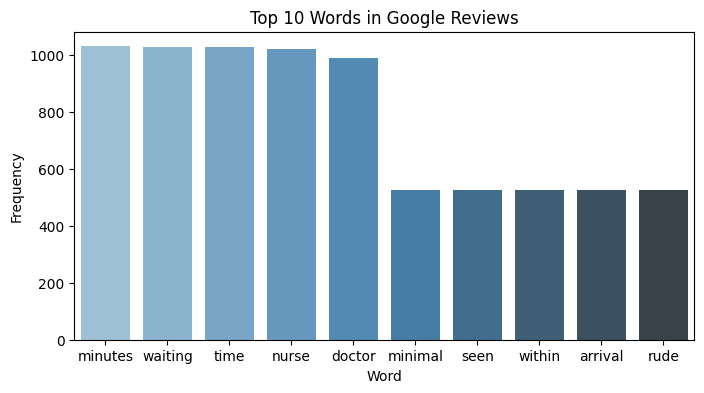

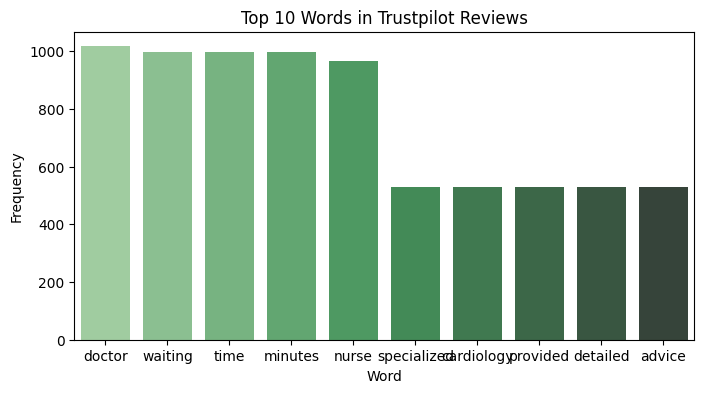

In [ ]:
# Google
plt.figure(figsize=(8,4))
sns.barplot(x=[w[0] for w in google_top10], y=[w[1] for w in google_top10], palette='Blues_d')
plt.title('Top 10 Words in Google Reviews')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()

# Trustpilot
plt.figure(figsize=(8,4))
sns.barplot(x=[w[0] for w in trustpilot_top10], y=[w[1] for w in trustpilot_top10], palette='Greens_d')
plt.title('Top 10 Words in Trustpilot Reviews')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()

# Use the wordcloud library on the cleaned data and plot the word cloud.

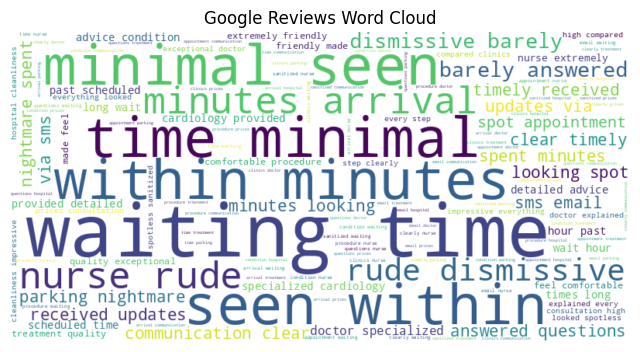

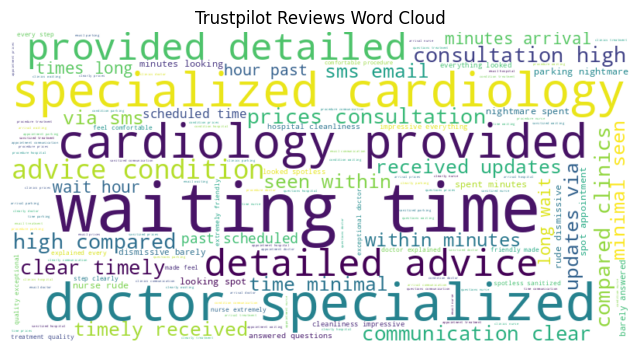

In [ ]:
# Join all tokens for wordcloud
google_text = ' '.join(google_words)
trustpilot_text = ' '.join(trustpilot_words)

# Google WordCloud
plt.figure(figsize=(8,6))
wc = WordCloud(width=800, height=400, background_color='white').generate(google_text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Google Reviews Word Cloud')
plt.show()

# Trustpilot WordCloud
plt.figure(figsize=(8,6))
wc = WordCloud(width=800, height=400, background_color='white').generate(trustpilot_text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Trustpilot Reviews Word Cloud')
plt.show()

# Save Cleaned Data for Later Use

In [ ]:
google_df.to_csv('Google_12_months_cleaned.csv', index=False)
trustpilot_df.to_csv('Trustpilot_12_months_cleaned.csv', index=False)

# Summary of Data Handling & Initial Analysis

- Downloaded and imported Google and Trustpilot reviews.
- Cleaned data: removed missing reviews, lowercased, removed stopwords/numbers, tokenized.
- Investigated word frequencies and visualized with bar plots and word clouds.

# **2.	Negative Review Analysis**

# Create a new dataframe by filtering out the data to extract only the negative reviews from both data sets.

# Identify Negative Reviews

- For Google reviews, negative: `score < 3`
- For Trustpilot reviews, negative: `stars < 3`

In [ ]:
# For Google reviews (negative if Overall Score < 3)
google_neg = google_df[google_df['Overall Score'] < 3].copy()

# For Trustpilot reviews (negative if Review Stars < 3)
trustpilot_neg = trustpilot_df[trustpilot_df['Review Stars'] < 3].copy()

In [ ]:
# Calculate number and percentage of negative reviews
num_google_neg = len(google_neg)
num_trustpilot_neg = len(trustpilot_neg)
percent_google_neg = (num_google_neg / len(google_df)) * 100
percent_trustpilot_neg = (num_trustpilot_neg / len(trustpilot_df)) * 100

print(f"Number of negative Google reviews: {num_google_neg} ({percent_google_neg:.2f}%)")
print(f"Number of negative Trustpilot reviews: {num_trustpilot_neg} ({percent_trustpilot_neg:.2f}%)")

Number of negative Google reviews: 2031 (40.62%)
Number of negative Trustpilot reviews: 2024 (40.48%)


# Repeat the frequency distribution and wordcloud steps on the filtered data consisting of only negative reviews.

# Word Frequency for Negative Reviews

In [ ]:
# Flatten the token list for negative reviews
google_neg_words = [word for tokens in google_neg['clean_tokens'] for word in tokens]
trustpilot_neg_words = [word for tokens in trustpilot_neg['clean_tokens'] for word in tokens]

# Frequency distribution
google_neg_freq = FreqDist(google_neg_words)
trustpilot_neg_freq = FreqDist(trustpilot_neg_words)

# Top 10 words
google_neg_top10 = google_neg_freq.most_common(10)
trustpilot_neg_top10 = trustpilot_neg_freq.most_common(10)

# Visualize: Histogram/Bar Plot for Negative Reviews

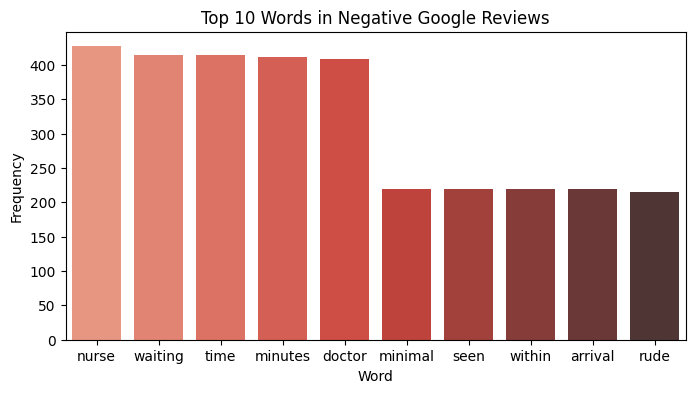

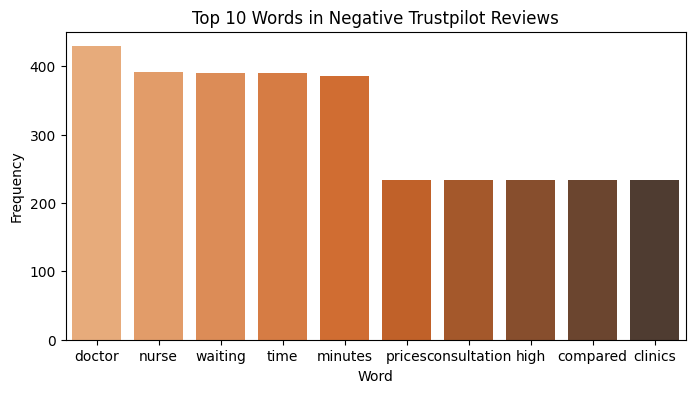

In [ ]:
# Google negative reviews
plt.figure(figsize=(8,4))
sns.barplot(x=[w[0] for w in google_neg_top10], y=[w[1] for w in google_neg_top10], palette='Reds_d')
plt.title('Top 10 Words in Negative Google Reviews')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()

# Trustpilot negative reviews
plt.figure(figsize=(8,4))
sns.barplot(x=[w[0] for w in trustpilot_neg_top10], y=[w[1] for w in trustpilot_neg_top10], palette='Oranges_d')
plt.title('Top 10 Words in Negative Trustpilot Reviews')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()

# Word Cloud for Negative Reviews

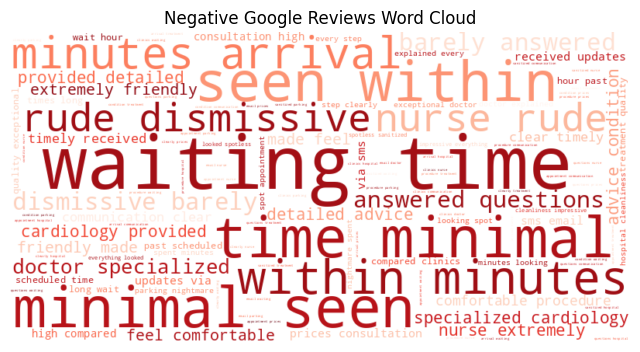

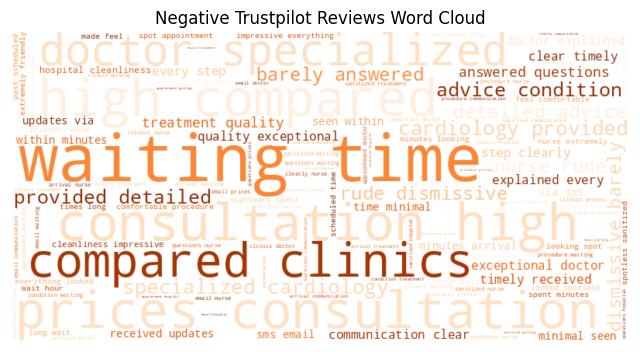

In [ ]:
# Join all tokens for wordcloud
google_neg_text = ' '.join(google_neg_words)
trustpilot_neg_text = ' '.join(trustpilot_neg_words)

# Google Negative WordCloud
plt.figure(figsize=(8,6))
wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(google_neg_text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Google Reviews Word Cloud')
plt.show()

# Trustpilot Negative WordCloud
plt.figure(figsize=(8,6))
wc = WordCloud(width=800, height=400, background_color='white', colormap='Oranges').generate(trustpilot_neg_text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Trustpilot Reviews Word Cloud')
plt.show()

# Summary of Negative Review Analysis

- Identified negative reviews for both datasets.
- Calculated word frequencies and visualized them with bar plots.
- Generated word clouds to highlight most common words in negative reviews.

# **3. Topic Modelling with BERTopic**

# With the data frame created in the previous step:

# • Filter out the reviews that are from the locations common to both data sets.

In [ ]:
# Filter Negative Reviews for Common Locations

# Identify location columns
google_location_col = "Club's Name"
trustpilot_location_col = "Location Name"

# Standardize location columns for both negative review dataframes
google_neg['location_std'] = google_neg[google_location_col].str.strip().str.lower()
trustpilot_neg['location_std'] = trustpilot_neg[trustpilot_location_col].str.strip().str.lower()

# Find common locations using standardized names
common_locations = set(google_neg['location_std'].unique()) & set(trustpilot_neg['location_std'].unique())
print(f"Number of common locations: {len(common_locations)}")

# Filter negative reviews to only those from common locations (using standardized column)
google_neg_common = google_neg[google_neg['location_std'].isin(common_locations)]
trustpilot_neg_common = trustpilot_neg[trustpilot_neg['location_std'].isin(common_locations)]

Number of common locations: 5


# • Merge the reviews to form a new list.

Note: DF is preferred for further analysis.

In [ ]:
google_neg_common['Source'] = 'Google'
trustpilot_neg_common['Source'] = 'Trustpilot'

# Unify the review columns
google_neg_common = google_neg_common.rename(columns={'Comment': 'Review'})
trustpilot_neg_common = trustpilot_neg_common.rename(columns={'Review Content': 'Review'})

merged_neg_reviews = pd.concat(
    [google_neg_common[['location_std', 'Review', 'Source']],
     trustpilot_neg_common[['location_std', 'Review', 'Source']]],
     ignore_index=True
)

# Save Merged Data for Later Use

In [ ]:
merged_neg_reviews.to_csv('merged_neg_reviews.csv', index=False)

# Preprocess this data set for BERTopic.

In [ ]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    return ' '.join(tokens)  # Re-join tokens into a string

# Apply to my merged DataFrame
merged_neg_reviews['cleaned_review'] = merged_neg_reviews['Review'].astype(str).apply(preprocess_text)

In [ ]:
# List of cleaned reviews, ready for BERTopic modeling
all_neg_reviews_common_cleaned = merged_neg_reviews['cleaned_review'].tolist()

In [ ]:
# Check the first few entries in the cleaned list
print(all_neg_reviews_common_cleaned[:10])  # Printing the first 10 elements to inspect


['communication clear timely received updates via sms email', 'prices consultation high compared clinics', 'communication clear timely received updates via sms email', 'nurse extremely friendly made feel comfortable procedure', 'nurse extremely friendly made feel comfortable procedure', 'hospital cleanliness impressive everything looked spotless sanitized', 'waiting times long wait hour past scheduled time', 'waiting time minimal seen within minutes arrival', 'prices consultation high compared clinics', 'hospital cleanliness impressive everything looked spotless sanitized']


# Use BERTopic on this cleaned data set.

In [ ]:
# Create and fit BERTopic model## Remove empty or whitespace-only reviews
all_neg_reviews_common_cleaned = [review for review in all_neg_reviews_common_cleaned if review.strip() != '']
topic_model = BERTopic(language="english", verbose=True)
topics, probs = topic_model.fit_transform(all_neg_reviews_common_cleaned)

2025-11-15 19:34:26,577 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/89 [00:00<?, ?it/s]

2025-11-15 19:34:28,134 - BERTopic - Embedding - Completed ✓
2025-11-15 19:34:28,135 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-15 19:35:00,305 - BERTopic - Dimensionality - Completed ✓
2025-11-15 19:35:00,306 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-15 19:35:00,383 - BERTopic - Cluster - Completed ✓
2025-11-15 19:35:00,386 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-15 19:35:00,411 - BERTopic - Representation - Completed ✓


# Output: List out the top topics along with their document frequencies.

In [ ]:
# Get topic information as a DataFrame
topic_info = topic_model.get_topic_info()

# Exclude the outlier topic (-1), which is usually "no topic"
topic_info = topic_info[topic_info.Topic != -1]

# Display the top N topics (by frequency)
N = 10  # or however many you want to display
print("Top topics and their document frequencies:")
print(topic_info[['Topic', 'Count', 'Name']].head(N))

Top topics and their document frequencies:
   Topic  Count                                      Name
0      0    308        0_consultation_clinics_prices_high
1      1    306  1_advice_cardiology_specialized_provided
2      2    299             2_seen_within_arrival_minimal
3      3    294          3_questions_barely_rude_answered
4      4    289               4_email_received_sms_timely
5      5    285          5_exceptional_every_step_quality
6      6    274    6_hospital_everything_sanitized_looked
7      7    270                    7_hour_long_times_wait
8      8    257        8_appointment_looking_spot_parking
9      9    255    9_comfortable_extremely_procedure_made


# For the top 2 topics, list out the top words.

In [ ]:
# Get the top 2 topics by frequency (excluding -1, which is usually "outlier" or "no topic")
top_topics = topic_info[topic_info.Topic != -1].head(2)

for idx, row in top_topics.iterrows():
    topic_num = row['Topic']
    top_words = [word for word, _ in topic_model.get_topic(topic_num)]
    print(f"Top words for topic {topic_num}: {', '.join(top_words[:10])}")

Top words for topic 0: consultation, clinics, prices, high, compared, , , , , 
Top words for topic 1: advice, cardiology, specialized, provided, condition, detailed, doctor, , , 


# Visualize Topic Clusters, Frequencies, Top Words

# Show an interactive visualisation of the topics to identify the cluster of topics and to understand the intertopic distance map.

In [ ]:
fig = topic_model.visualize_topics()
fig.show()

# Show a bar chart of the topics, displaying the top 5 words in each topic.

In [ ]:
topic_model.visualize_barchart(top_n_topics=5)

# Plot a heatmap, showcasing the similarity matrix.

In [ ]:
topic_model.visualize_heatmap()

# For 10 clusters, provide a brief description in the Notebook of the topics they comprise of along with the general theme of the cluster, evidenced by the top words within each cluster's topics.



In [ ]:
# Show top 10 topics and their most representative words
for topic_id in topic_info['Topic'].head(10):
    if topic_id == -1:  # -1 is often the outlier/noise topic
        continue
    print(f"\nTopic {topic_id}:")
    words = topic_model.get_topic(topic_id)  # List of (word, weight)
    print("Top words:", ', '.join([w[0] for w in words[:8]]))
    # Optionally, print a few example documents from each topi_c:
    docs = [all_neg_reviews_common_cleaned[i] for i, t in enumerate(topics) if t == topic_id][:2]
    print("Example reviews:", docs)


Topic 0:
Top words: consultation, clinics, prices, high, compared, , , 
Example reviews: ['prices consultation high compared clinics', 'prices consultation high compared clinics']

Topic 1:
Top words: advice, cardiology, specialized, provided, condition, detailed, doctor, 
Example reviews: ['doctor specialized cardiology provided detailed advice condition', 'doctor specialized cardiology provided detailed advice condition']

Topic 2:
Top words: seen, within, arrival, minimal, minutes, time, waiting, 
Example reviews: ['waiting time minimal seen within minutes arrival', 'waiting time minimal seen within minutes arrival']

Topic 3:
Top words: questions, barely, rude, answered, dismissive, nurse, , 
Example reviews: ['nurse rude dismissive barely answered questions', 'nurse rude dismissive barely answered questions']

Topic 4:
Top words: email, received, sms, timely, updates, via, clear, communication
Example reviews: ['communication clear timely received updates via sms email', 'communi

# **4. Location Analysis**

# Find Top 20 Locations with the Most Negative Reviews in Each Dataset

# List out the top 20 locations with the highest number of negative reviews. Do this separately for Google and Trustpilot's reviews, and comment on the result.

In [ ]:
# For Google
google_neg_location_counts = google_neg.groupby("Club's Name").size().sort_values(ascending=False)
google_top20_locs = google_neg_location_counts.head(20)
print("Top 20 Google locations with most negative reviews:\n", google_top20_locs)

Top 20 Google locations with most negative reviews:
 Club's Name
Cambridge Leisure Park               202
Liverpool Care Center                185
Miami Wellness                       173
Leeds City Centre North              172
Dallas Care                          170
Cheshunt Brookfield Shopping Park    167
London Holborn                       165
Manchester Health Hub                164
Birmingham Wellness                  163
Chicago Health Hub                   162
New York Clinic                      157
Los Angeles Center                   151
dtype: int64


In [ ]:
# For Trustpilot
trustpilot_neg_location_counts = trustpilot_neg.groupby("Location Name").size().sort_values(ascending=False)
trustpilot_top20_locs = trustpilot_neg_location_counts.head(20)
print("Top 20 Trustpilot locations with most negative reviews:\n", trustpilot_top20_locs)

Top 20 Trustpilot locations with most negative reviews:
 Location Name
Dallas Care           413
Miami Wellness        410
Los Angeles Center    408
Chicago Health Hub    403
New York Clinic       390
dtype: int64


In [ ]:
# Get the set of top 20 locations from each dataset
google_top20_set = set(google_top20_locs.index)
trustpilot_top20_set = set(trustpilot_top20_locs.index)

# Find the intersection (common locations)
common_locations = google_top20_set.intersection(trustpilot_top20_set)

# Calculate the number and percentage of common locations
num_common = len(common_locations)
total_possible = min(len(google_top20_set), len(trustpilot_top20_set))  # usually 20
percentage_common = (num_common / total_possible) * 100

# Display results
print(f"Common locations in both data sets ({num_common} out of {total_possible}, {percentage_common:.1f}%):")
for loc in common_locations:
    print(f"- {loc}")

Common locations in both data sets (5 out of 5, 100.0%):
- Dallas Care
- Los Angeles Center
- Miami Wellness
- Chicago Health Hub
- New York Clinic


# Merge the 2 data sets using Location Name and Club's Name.

# Now, list out the following:

# • Locations

# • Number of Trustpilot reviews for this location

# • Number of Google reviews for this location

# • Total number of reviews for this location (sum of Google reviews and Trustpilot reviews)

# Sort based on the total number of reviews.

In [ ]:
# Extract top 20 locations from each dataset
google_top20_locs = google_neg.groupby("Club's Name").size().sort_values(ascending=False).head(20)
trustpilot_top20_locs = trustpilot_neg.groupby("Location Name").size().sort_values(ascending=False).head(20)

# Step 1: Create DataFrames for both Google and Trustpilot review counts
google_reviews = google_top20_locs.reset_index(name="Google Reviews")
google_reviews = google_reviews.rename(columns={"Club's Name": "Location Name"})  # Ensure consistent column name

trustpilot_reviews = trustpilot_top20_locs.reset_index(name="Trustpilot Reviews")
trustpilot_reviews = trustpilot_reviews.rename(columns={"Location Name": "Location Name"})

# Step 2: Merge the two DataFrames on 'Location Name', using outer join to include all unique locations
merged_reviews = pd.merge(google_reviews, trustpilot_reviews, on="Location Name", how="outer")

# Step 3: Fill NaN values with 0 (in case a location doesn't have reviews in either dataset)
merged_reviews = merged_reviews.fillna(0)

# Step 4: Calculate the total reviews (sum of Google and Trustpilot reviews)
merged_reviews["Total Reviews"] = merged_reviews["Google Reviews"] + merged_reviews["Trustpilot Reviews"]

# Step 5: Sort by total reviews (descending)
merged_reviews_sorted = merged_reviews.sort_values(by="Total Reviews", ascending=False)

# Step 6: Display the table in a nice format using tabulate
formatted_table = tabulate(
    merged_reviews_sorted[['Location Name', 'Trustpilot Reviews', 'Google Reviews', 'Total Reviews']].values,
    headers=['Location Name', 'Trustpilot Reviews', 'Google Reviews', 'Total Reviews'],
    tablefmt='grid'
)

# Print the formatted table
print(formatted_table)

+-----------------------------------+----------------------+------------------+-----------------+
| Location Name                     |   Trustpilot Reviews |   Google Reviews |   Total Reviews |
+===================================+======================+==================+=================+
| Miami Wellness                    |                  410 |              173 |             583 |
+-----------------------------------+----------------------+------------------+-----------------+
| Dallas Care                       |                  413 |              170 |             583 |
+-----------------------------------+----------------------+------------------+-----------------+
| Chicago Health Hub                |                  403 |              162 |             565 |
+-----------------------------------+----------------------+------------------+-----------------+
| Los Angeles Center                |                  408 |              151 |             559 |
+-------------------

# Save merged and sorted reviews

In [ ]:
# Save the merged and sorted DF
merged_reviews_sorted.to_csv("top_merged_location_reviews.csv", index=False)

# Topic Modelling for Top 30 Locations

In [ ]:
# Get top 30 locations by total reviews
top30_locations = merged_reviews_sorted.head(30)

# Print just the locations
print("Top 30 Locations Based on Total Reviews:\n")
for location in top30_locations['Location Name']:
    print(location)

Top 30 Locations Based on Total Reviews:

Miami Wellness
Dallas Care
Chicago Health Hub
Los Angeles Center
New York Clinic
Cambridge Leisure Park
Liverpool Care Center
Leeds City Centre North
Cheshunt Brookfield Shopping Park
London Holborn
Manchester Health Hub
Birmingham Wellness


In [ ]:
print(top30_locations.columns)

Index(['Location Name', 'Google Reviews', 'Trustpilot Reviews',
       'Total Reviews'],
      dtype='object')


# Filtering the negative reviews from both Google and Trustpilot datasets for top 30 locations

In [ ]:
def normalize_location(name):
    if pd.isna(name):
        return ""
    # Convert to string first, then strip and lowercase
    return str(name).strip().lower()

# dataframe column:
top30_locations['location_std'] = top30_locations['Location Name'].apply(normalize_location)

# Normalize location names in google_neg and trustpilot_neg
google_neg['location_std'] = google_neg["Club's Name"].apply(normalize_location)
trustpilot_neg['location_std'] = trustpilot_neg["Location Name"].apply(normalize_location)

# Get list of normalized top 30 locations
top30_locs_std = top30_locations['location_std'].unique().tolist()

# Filter negative reviews for top 30 locations using normalized column
google_neg_top30 = google_neg[google_neg['location_std'].isin(top30_locs_std)].copy()
trustpilot_neg_top30 = trustpilot_neg[trustpilot_neg['location_std'].isin(top30_locs_std)].copy()

# Rename columns for consistency
google_neg_top30 = google_neg_top30.rename(columns={"Club's Name": "Location", "Comment": "Review"})
trustpilot_neg_top30 = trustpilot_neg_top30.rename(columns={"Location Name": "Location", "Review Content": "Review"})

# Add source columns
google_neg_top30['Source'] = 'Google'
trustpilot_neg_top30['Source'] = 'Trustpilot'

# Select only needed columns
google_subset = google_neg_top30[['Location', 'Review', 'Source']]
trustpilot_subset = trustpilot_neg_top30[['Location', 'Review', 'Source']]

# Combine datasets
combined_neg_reviews = pd.concat([google_subset, trustpilot_subset], ignore_index=True)

print(f"Combined negative reviews count: {combined_neg_reviews.shape[0]}")
print(combined_neg_reviews.head())

Combined negative reviews count: 4055
                  Location                                             Review  \
0    Manchester Health Hub  Waiting time was minimal, I was seen within 10...   
1           London Holborn  Waiting time was minimal, I was seen within 10...   
2       Chicago Health Hub  Communication was clear and timely, received a...   
3  Leeds City Centre North  Nurse was rude and dismissive, barely answered...   
4   Cambridge Leisure Park  Prices for the consultation were too high comp...   

   Source  
0  Google  
1  Google  
2  Google  
3  Google  
4  Google  


In [ ]:
print(combined_neg_reviews['Source'].value_counts())

Source
Google        2031
Trustpilot    2024
Name: count, dtype: int64


# For the top 30 locations, redo the word frequency and word cloud. Comment on the results, and highlight if the results are different from the first run.

In [ ]:
# Combine all reviews into a single string (lowercase, remove punctuation)
all_reviews = " ".join(combined_neg_reviews['Review'].dropna().astype(str)).lower()

# Remove punctuation and digits
all_reviews_clean = re.sub(r'[^a-z\s]', '', all_reviews)

# Define the stopwords (from NLTK)
stop_words = set(stopwords.words('english'))

# Custom stopwords you want to remove manually
custom_stopwords = {'get', 'one', 'always', 'also', 'dont', 'even', 'like', 'use', 'would', 'im', 'go', 'ive', 'puregym', 'pure'}

# Update stopwords list to include custom stopwords
combined_stopwords = stop_words.union(custom_stopwords)

# Tokenize and remove stopwords
tokens = [word for word in all_reviews_clean.split() if word not in combined_stopwords]

# Count word frequencies
word_freq = Counter(tokens)

# Display top 30 words
top_10_words = word_freq.most_common(10)
print("Top 10 most common words in negative reviews (top 30 locations):")
for word, freq in top_10_words:
    print(f"{word}: {freq}")

Top 10 most common words in negative reviews (top 30 locations):
doctor: 837
nurse: 818
waiting: 805
time: 805
minutes: 796
specialized: 439
cardiology: 439
provided: 439
detailed: 439
advice: 439


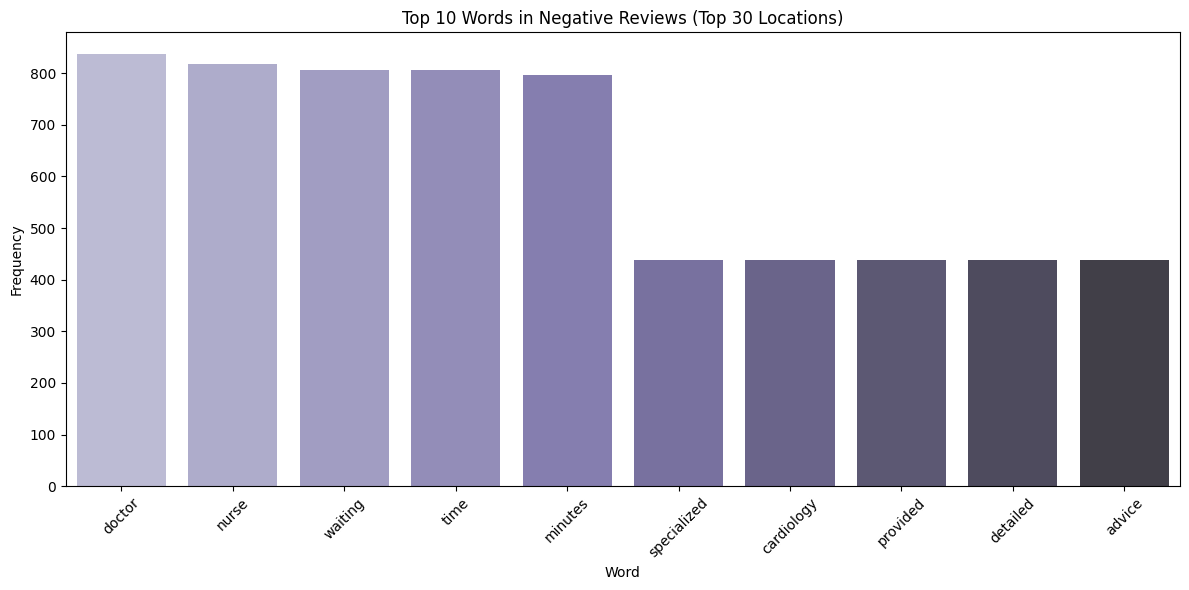

In [ ]:
# Unpack words and frequencies from top_30_words
words = [w[0] for w in top_10_words]
freqs = [w[1] for w in top_10_words]

# Plot barplot (histogram-like)
plt.figure(figsize=(12,6))
sns.barplot(x=words, y=freqs, palette='Purples_d')
plt.title('Top 10 Words in Negative Reviews (Top 30 Locations)')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

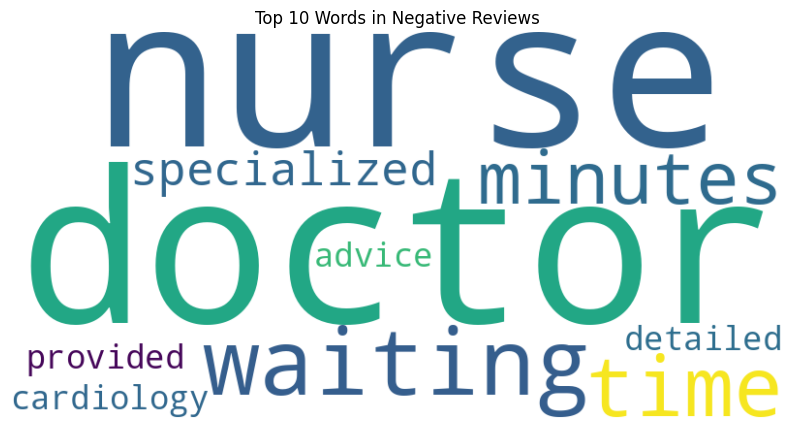

In [ ]:
# Create a WordCloud from the top 10 words (we only use words and frequencies)
top_10_dict = dict(top_10_words)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_10_dict)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.title('Top 10 Words in Negative Reviews')
plt.show()

# Redo Topic Modelling with BERTopic for top 30

In [ ]:
# Clean each review individually
cleaned_reviews = []

# Define the stopwords (from NLTK)
stop_words = set(stopwords.words('english'))

# Custom stopwords you want to remove manually
custom_stopwords = {'get', 'one', 'always', 'also', 'dont', 'even', 'like', 'use', 'would', 'im', 'go', 'ive', 'puregym', 'pure'}

# Update stopwords list to include custom stopwords
combined_stopwords = stop_words.union(custom_stopwords)

# Iterate over each review and clean it
for review in combined_neg_reviews['Review'].dropna():
    # Convert to lowercase and remove non-alphabetic characters
    review_clean = re.sub(r'[^a-z\s]', '', review.lower())

    # Tokenize and remove stopwords
    tokens = [word for word in review_clean.split() if word not in combined_stopwords]

    # Join tokens back into a single cleaned review string
    cleaned_reviews.append(' '.join(tokens))

# Initialize the BERTopic model
topic_model_neg_reviews = BERTopic(language="english", verbose=True)

# Fit the model to the cleaned reviews and get topics and probabilities
topics_neg_reviews, probs_neg_reviews = topic_model_neg_reviews.fit_transform(cleaned_reviews)

2025-11-15 19:35:01,296 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/127 [00:00<?, ?it/s]

2025-11-15 19:35:03,610 - BERTopic - Embedding - Completed ✓
2025-11-15 19:35:03,611 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-15 19:35:55,787 - BERTopic - Dimensionality - Completed ✓
2025-11-15 19:35:55,788 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-15 19:35:55,901 - BERTopic - Cluster - Completed ✓
2025-11-15 19:35:55,905 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-15 19:35:55,936 - BERTopic - Representation - Completed ✓


In [ ]:
# Get topic information as a DataFrame
topic_info = topic_model_neg_reviews.get_topic_info()

# Exclude the outlier topic (-1), which is usually "no topic"
topic_info = topic_info[topic_info.Topic != -1]

# Display the top N topics (by frequency)
N = 10  # or however many you want to display
print("Top topics and their document frequencies:")
print(topic_info[['Topic', 'Count', 'Name']].head(N))

Top topics and their document frequencies:
   Topic  Count                                      Name
0      0    439  0_advice_cardiology_specialized_provided
1      1    430        1_consultation_clinics_prices_high
2      2    426          2_questions_barely_rude_answered
3      3    420             3_seen_within_arrival_minimal
4      4    408               4_email_received_sms_timely
5      5    398          5_exceptional_every_step_quality
6      6    392    6_comfortable_extremely_procedure_made
7      7    385                    7_hour_long_times_wait
8      8    381    8_hospital_everything_sanitized_looked
9      9    376        9_appointment_looking_spot_parking


# Bar Chart: Top Words per Topic for top 30

In [ ]:
topic_model_neg_reviews.visualize_barchart(top_n_topics=5)

# Heatmap: Topic Similarities for top 30

In [ ]:
# Visualize heatmap
topic_model_neg_reviews.visualize_topics()
topic_model_neg_reviews.visualize_barchart(top_n_topics=10)
topic_model_neg_reviews.visualize_heatmap()

# For the top 30 locations, combine the reviews from Google and Trustpilot and run them through BERTopic.


# Comment on the following:

# • Are the results any different from the first run of BERTopic?

# • If so, what has changed?

# • Are there any additional insights compared to the first run?

# Summary of Topic Modelling with BERTopic for top 30

- Identified top locations with most negative reviews in each dataset.
- Merged datasets to analyze top 30 locations overall.
- Repeated word frequency, word cloud, and topic modeling analysis for these key locations.

# **5. Emotion Analysis**

Note: `nateraw/bert-base-uncased-emotion` model predicts emotions anger, disgust, fear, joy, sadness and surprise (six in total).

# Use BERT Emotion Classifier to Analyze Negative Reviews

# Import the BERT model bhadresh-savani/bert-base-uncased-emotion from Hugging Face, and set up a pipeline for text classification.

In [ ]:
# Set up the Hugging Face pipeline for emotion classification
emotion_classifier = pipeline("text-classification", model="nateraw/bert-base-uncased-emotion", tokenizer="nateraw/bert-base-uncased-emotion")

Device set to use cuda:0


# With the help of an example sentence, run the model and display the different emotion classifications that the model outputs.

In [ ]:
# Example sentence
text = "Every time I see my dog, my heart fills with love and happiness."

# Get emotion prediction for the sentence
emotion_result = emotion_classifier(text)

# Print the classification result
print(emotion_result)

[{'label': 'joy', 'score': 0.8487599492073059}]


# Run this model on both data sets

In [ ]:
from transformers import pipeline

# Set up the Hugging Face pipeline for emotion classification
emotion_classifier = pipeline(
    "text-classification",
    model="nateraw/bert-base-uncased-emotion",
    tokenizer="nateraw/bert-base-uncased-emotion",
    device=0  # Set to -1 for CPU, 0 for GPU
)

# Modify the function to handle truncation and padding explicitly
def get_top_emotion(review):
    # Tokenize with truncation and padding
    result = emotion_classifier(review, padding=True, truncation=True, max_length=512)
    # Return the predicted label (emotion)
    return result[0]['label']

# Sampling a smaller portion of the data
sample_size = 1000  # To reduce runtime; can be changed

# Sample 100 random rows from the Google reviews dataframe
google_sample = google_df.sample(n=sample_size, random_state=42)

# Sample 100 random rows from the Trustpilot reviews dataframe
trustpilot_sample = trustpilot_df.sample(n=sample_size, random_state=42)

# Apply the emotion prediction to the sampled Google and Trustpilot reviews
google_sample['predicted_emotion'] = google_sample['Comment'].apply(get_top_emotion)
trustpilot_sample['predicted_emotion'] = trustpilot_sample['Review Content'].apply(get_top_emotion)

# Print the results for the sample
print("Sampled Google Reviews Emotions:")
print(google_sample[['Comment', 'predicted_emotion']])

print("\nSampled Trustpilot Reviews Emotions:")
print(trustpilot_sample[['Review Content', 'predicted_emotion']])

Device set to use cuda:0


Sampled Google Reviews Emotions:
                                                Comment predicted_emotion
1501  Waiting times were too long, had to wait over ...             anger
2586  Nurse was extremely friendly and made me feel ...               joy
2653  Parking was a nightmare, spent 30 minutes look...              fear
1055  Prices for the consultation were too high comp...             anger
705   Communication was clear and timely, received a...               joy
...                                                 ...               ...
4711  Doctor specialized in cardiology and provided ...               joy
2313  Treatment quality was exceptional, the doctor ...               joy
3214  Nurse was extremely friendly and made me feel ...               joy
2732  Treatment quality was exceptional, the doctor ...               joy
1926  Doctor specialized in cardiology and provided ...               joy

[1000 rows x 2 columns]

Sampled Trustpilot Reviews Emotions:
                

# Capture the top emotion for each review

In [ ]:
# Find the top 3 most common emotions in the sampled reviews
google_top_3_emotions = google_sample['predicted_emotion'].value_counts().head(3)
trustpilot_top_3_emotions = trustpilot_sample['predicted_emotion'].value_counts().head(3)

print("\nTop 3 Emotions in Google Reviews Sample:")
print(google_top_3_emotions)

print("\nTop 3 Emotions in Trustpilot Reviews Sample:")
print(trustpilot_top_3_emotions)


Top 3 Emotions in Google Reviews Sample:
predicted_emotion
joy      588
anger    320
fear      92
Name: count, dtype: int64

Top 3 Emotions in Trustpilot Reviews Sample:
predicted_emotion
joy      614
anger    289
fear      97
Name: count, dtype: int64


# Use a bar plot to show the top emotion distribution for all negative reviews in both data sets.

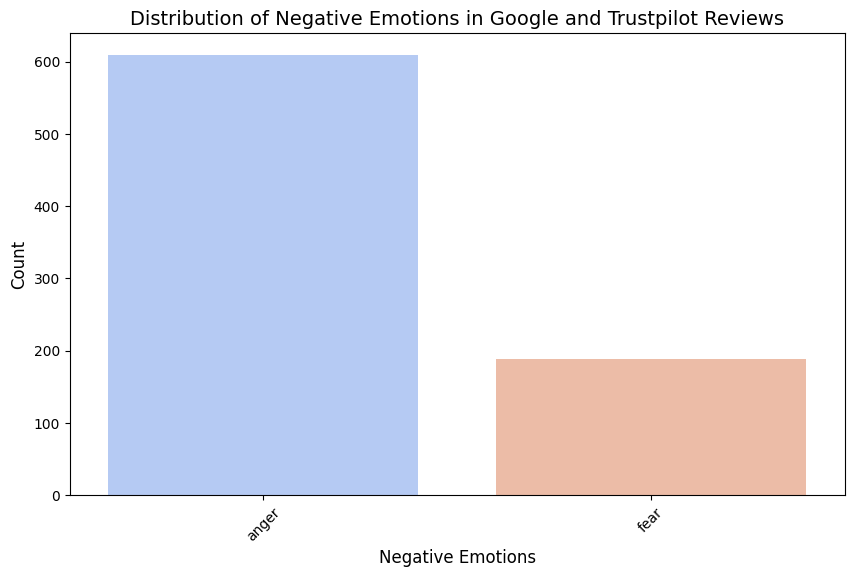

In [ ]:
# Define a list of negative emotions
negative_emotions = ['sadness', 'anger', 'fear']

# Filter the Google reviews to keep only negative emotions
google_negative = google_sample[google_sample['predicted_emotion'].isin(negative_emotions)]

# Filter the Trustpilot reviews to keep only negative emotions
trustpilot_negative = trustpilot_sample[trustpilot_sample['predicted_emotion'].isin(negative_emotions)]

# Combine the data for both datasets
combined_negative_emotions = pd.concat([google_negative['predicted_emotion'], trustpilot_negative['predicted_emotion']], axis=0)

# Plot the distribution of negative emotions
plt.figure(figsize=(10, 6))
sns.countplot(x=combined_negative_emotions, palette='coolwarm')

# Set plot title and labels
plt.title('Distribution of Negative Emotions in Google and Trustpilot Reviews', fontsize=14)
plt.xlabel('Negative Emotions', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

# Show plot
plt.show()


# Below is to check if the bar chart makes sense

In [ ]:
# Count the occurrences of each emotion in the sampled data for Google and Trustpilot
google_emotion_counts = google_sample['predicted_emotion'].value_counts()
trustpilot_emotion_counts = trustpilot_sample['predicted_emotion'].value_counts()

# Print the distribution of emotions in the samples
print("Emotion distribution in Google Reviews Sample:")
print(google_emotion_counts)

print("\nEmotion distribution in Trustpilot Reviews Sample:")
print(trustpilot_emotion_counts)


Emotion distribution in Google Reviews Sample:
predicted_emotion
joy      588
anger    320
fear      92
Name: count, dtype: int64

Emotion distribution in Trustpilot Reviews Sample:
predicted_emotion
joy      614
anger    289
fear      97
Name: count, dtype: int64


# Extract all the negative reviews (from both data sets) where anger is top emotion.

In [ ]:
# Extract reviews from Google where 'Anger' is the predicted emotion
google_anger_reviews = google_sample[google_sample['predicted_emotion'] == 'anger']

# Extract reviews from Trustpilot where 'Anger' is the predicted emotion
trustpilot_anger_reviews = trustpilot_sample[trustpilot_sample['predicted_emotion'] == 'anger']

# Print the reviews with 'Anger' emotion for both datasets
print("Google Reviews with 'Anger' Emotion:")
print(google_anger_reviews[['Comment', 'predicted_emotion']])

print("\nTrustpilot Reviews with 'Anger' Emotion:")
print(trustpilot_anger_reviews[['Review Content', 'predicted_emotion']])

Google Reviews with 'Anger' Emotion:
                                                Comment predicted_emotion
1501  Waiting times were too long, had to wait over ...             anger
1055  Prices for the consultation were too high comp...             anger
106   Prices for the consultation were too high comp...             anger
2468  Waiting times were too long, had to wait over ...             anger
1600  Waiting times were too long, had to wait over ...             anger
...                                                 ...               ...
192   Waiting times were too long, had to wait over ...             anger
4849  Nurse was rude and dismissive, barely answered...             anger
4939  Prices for the consultation were too high comp...             anger
944   Nurse was rude and dismissive, barely answered...             anger
4424  Prices for the consultation were too high comp...             anger

[320 rows x 2 columns]

Trustpilot Reviews with 'Anger' Emotion:
         

# Run BERTopic on the output of the previous step.

In [ ]:
def preprocess_text(text):
 text = text.lower()
 text = re.sub(r'\d+', '', text)
 text = text.translate(str.maketrans('', '', string.punctuation))
 tokens = word_tokenize(text)
 tokens = [word for word in tokens if word not in stop_words and len(word) >1]
 return " ".join(tokens)

# Apply preprocessing to the anger reviews
google_anger_reviews['cleaned_review'] = google_anger_reviews['Comment'].apply(preprocess_text)
trustpilot_anger_reviews['cleaned_review'] = trustpilot_anger_reviews['Review Content'].apply(preprocess_text)

# Combine both datasets for topic modeling
all_anger_reviews = pd.concat([google_anger_reviews['cleaned_review'], trustpilot_anger_reviews['cleaned_review']], axis=0).tolist()

# Remove any empty strings from the list
all_anger_reviews = [review for review in all_anger_reviews if review.strip() != '']

# Set up the BERTopic model with a minimum number of topics
topic_model = BERTopic(language="english", verbose=True, min_topic_size=5)

# Fit the model to the anger reviews
topics, probs = topic_model.fit_transform(all_anger_reviews)

print(topic_info[['Topic', 'Count', 'Name']].head(10))

2025-11-15 19:36:14,463 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/20 [00:00<?, ?it/s]

2025-11-15 19:36:15,590 - BERTopic - Embedding - Completed ✓
2025-11-15 19:36:15,590 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-15 19:36:20,624 - BERTopic - Dimensionality - Completed ✓
2025-11-15 19:36:20,625 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-15 19:36:20,644 - BERTopic - Cluster - Completed ✓
2025-11-15 19:36:20,646 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-15 19:36:20,656 - BERTopic - Representation - Completed ✓


   Topic  Count                                      Name
0      0    439  0_advice_cardiology_specialized_provided
1      1    430        1_consultation_clinics_prices_high
2      2    426          2_questions_barely_rude_answered
3      3    420             3_seen_within_arrival_minimal
4      4    408               4_email_received_sms_timely
5      5    398          5_exceptional_every_step_quality
6      6    392    6_comfortable_extremely_procedure_made
7      7    385                    7_hour_long_times_wait
8      8    381    8_hospital_everything_sanitized_looked
9      9    376        9_appointment_looking_spot_parking


In [ ]:
# Visualize the top 5 topics as a bar chart
topic_model.visualize_barchart(top_n_topics=5)

In [ ]:
print(len(all_neg_reviews_common_cleaned))


2837


In [ ]:
print(topics[:20])  # See the first 20 topic assignments
print(set(topics))  # See all unique topics assigned


[0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 1, 0, 2, 1, 1, 0, 1, 1]
{0, 1, 2, 3}


In [ ]:
# Visualize topics with a heatmap
topic_model.visualize_topics()
topic_model.visualize_barchart(top_n_topics=10)
topic_model.visualize_heatmap()